<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/46-FaceMaskDetection/46_FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, AveragePooling2D, Dropout, Conv2D, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
import cv2
import numpy as np
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Config wandb

In [ ]:
wandb.init(project= "Face_Mask")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
config = wandb.config
# config.learning_rate = 0.0001

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset_path = "/content/drive/MyDrive/datasets/FaceMask/Train"
validation_dataset_path = "/content/drive/MyDrive/datasets/FaceMask/Validation"
width = height = 224
batch_size= 32

idg = ImageDataGenerator(
    rescale= 1./255, 
    rotation_range= 10, 
    brightness_range= (0.8, 1.2), 
    shear_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=True,     
    # validation_split=0.2   
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    # subset = "training"    

)

validation_data = idg.flow_from_directory(
    validation_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    # subset = "validation"
)

Found 10010 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


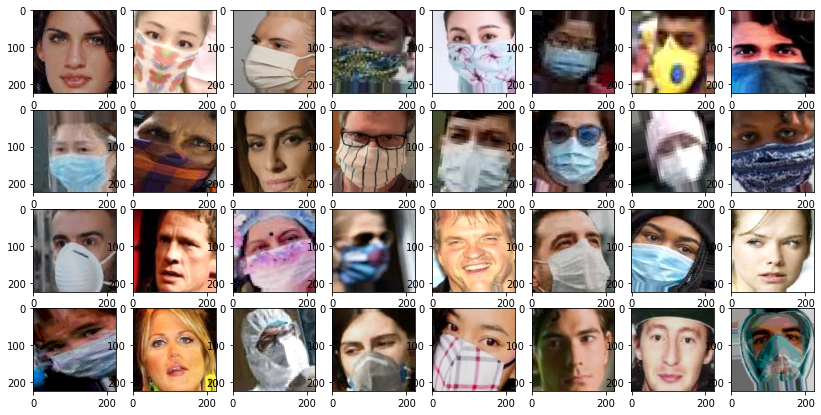

In [ ]:
some_images = next(train_data)
X=some_images[0]
Y=some_images[1]

plt.figure(figsize=(14,7))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(X[i])

# Model

In [ ]:
# customize base model
base_model = tf.keras.applications.MobileNetV2(
)
base_model.summary()


14548992/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [ ]:
# customize base model
base_model = tf.keras.applications.MobileNetV2(
    include_top = False,
    input_shape = (width, height, 3),
    weights = "imagenet",
    pooling="avg"
)



9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# freez Layer
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
model = tf.keras.models.Sequential([
    base_model,
    Dropout(0.2),
    # Conv2D(32,(3,3)),
    # Reshape(),
    Dense(2, activation='softmax')
])

In [ ]:
model.compile( optimizer= tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

Callback save model (each epoch)

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
        print("End epoch {} of training;".format(epoch))
        ep = "epoch_{}".format(epoch)
        dir = "/content/drive/MyDrive/models/FaceMask/FaceMask"
        name = "{}_{}.h5".format(dir, ep)
        print(name)
        model.save(name)

# Train

In [ ]:
model_history = model.fit(train_data, validation_data= validation_data, epochs= 10, callbacks=[CustomCallback(), WandbCallback()])

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.9655End epoch 0 of training;
/content/drive/MyDrive/models/FaceMask/FaceMask_epoch_0.h5
313/313 [==============================] - 2589s 8s/step - loss: 0.0911 - accuracy: 0.9655 - val_loss: 0.0257 - val_accuracy: 0.9937 - _timestamp: 1649538169.0000 - _runtime: 3334.0000
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9887End epoch 1 of training;
/content/drive/MyDrive/models/FaceMask/FaceMask_epoch_1.h5
313/313 [==============================] - 200s 638ms/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 0.0191 - val_accuracy: 0.9912 - _timestamp: 1649538369.0000 - _runtime: 3534.0000
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9895End epoch 2 of training;
/content/drive/MyDrive/models/FaceMask/FaceMask_epoch_2.h5
313/313 [==============================] - 198s 634ms/step - loss: 0.0335 - accuracy: 0.989

In [ ]:
# model_history2 = model.fit(train_data, validation_data= validation_data, epochs= 5, callbacks=[CustomCallback(), WandbCallback()])

In [ ]:
model.save('/content/drive/MyDrive/models/FaceMask/46_FaceMask.h5')

In [ ]:
# select best model (best validation accuracy)

# model = load_model('/content/drive/MyDrive/models/17-flowers/17-flowers_epoch_15.h5')

In [ ]:
# model = load_model('/content/drive/MyDrive/models/17-flowers/46_17_flowers_Xception2.h5')

# Test


In [ ]:
test_dataset_path = "/content/drive/MyDrive/datasets/FaceMask/Test"

width = height = 224
batchSize = 32

idg = ImageDataGenerator(
    rescale = 1./255
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
    batch_size=batch_size,
)

Found 992 images belonging to 2 classes.


In [ ]:
test_loss, test_acc= model.evaluate(test_data)
print(test_loss)
print(test_acc)

31/31 [==============================] - 121s 4s/step - loss: 0.0260 - accuracy: 0.9899
0.026015277951955795
0.9899193644523621


# Confusion matrix

[[480   3]
 [ 16 493]]


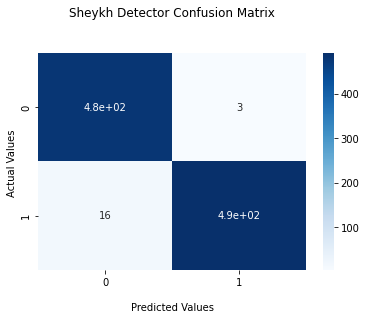

In [ ]:
Y_pred = []

for path in test_data.filepaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    image = image / 255
    image = image.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(image)))

cv_confMTX = confusion_matrix(test_data.classes, Y_pred)
print(cv_confMTX)

ax = sns.heatmap(cv_confMTX, annot=True, cmap='Blues')
ax.set_title('Sheykh Detector Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.show()

# Inference

In [ ]:
image_path = "/content/drive/MyDrive/datasets/Inference/FaceMask/01.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 image color format !# tensorflow image color format
image = cv2.resize(image, (width, height))
image = image / 255
image = image.reshape(1, width, height, 3)
result = model.predict(image)
print(result)
pred = np.argmax(result)
print(pred)


error: ignored